# scaredyrat-FC analyzes data from fear conditioning protocol

In [1]:
# notebook formatting and loading settings, imports - keep same

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os, sys

sys.path.append('./src')
import scaredyrattools as sr
import scaredyratfunctions as srf

# Change variables in this cell:

In [2]:
inpath = r'C:\Users\Sean\Desktop\ShanskyLab_Projects\Data\MindlinProj\RawdataforSR'

outpath = r'C:\Users\Sean\Desktop\ShanskyLab_Projects\Data\MindlinProj\RawdataforSR\SR_OUT'

## Search the inpath for files
filelist = []
for entry in os.scandir(inpath):
    if entry.is_file():
        filelist.append(entry.path)

In [3]:
inpath = r'C:\Users\Sean\Desktop\ShanskyLab_Projects\Data\MindlinProj\RawdataforSR'

outpath = r'C:\Users\Sean\Desktop\ShanskyLab_Projects\Data\MindlinProj\RawdataforSR\SR_OUT'

## Search the inpath for files
filelist = [r'Raw data-Mindlin Project Fear Conditioning-Trial     2.xlsx']

In [4]:
## don't need to change this - stays constant across files
sheetlist = ['Track-Arena 1-Subject 1', 'Track-Arena 2-Subject 1', 
             'Track-Arena 3-Subject 1', 'Track-Arena 4-Subject 1']

# Function calls below

C:\Users\Sean\Anaconda3\lib\site-packages\pandas\util\_decorators.py:177: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)
C:\Users\Sean\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


Raw data-Mindlin Project Fear Conditioning-Trial     2.xlsx Track-Arena 1-Subject 1 is JF1 in 2 Tone Test
2 Tone Test
JF1
twotone


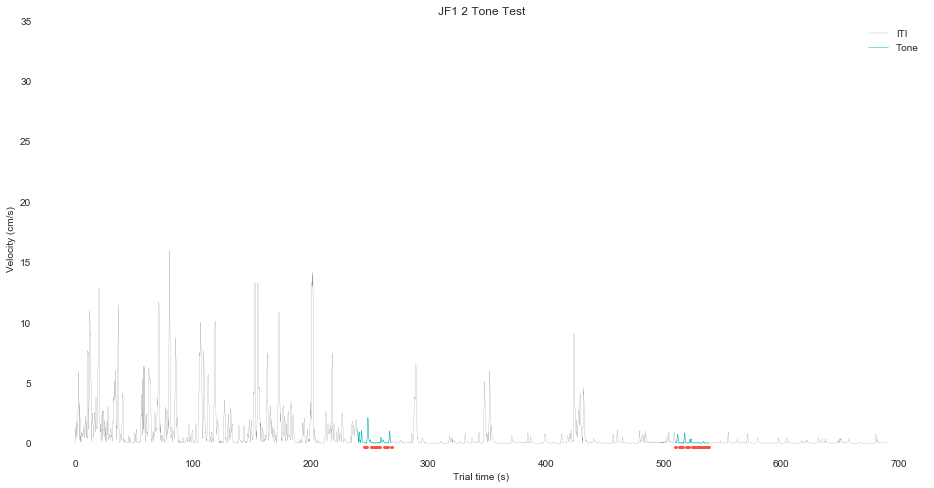

Raw data-Mindlin Project Fear Conditioning-Trial     2.xlsx Track-Arena 2-Subject 1 is JF2 in 2 Tone Test
2 Tone Test
JF2
twotone


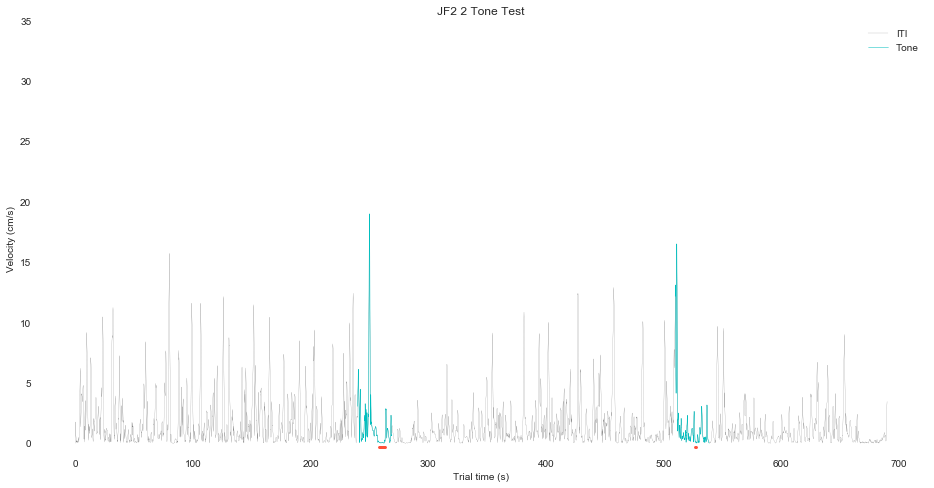

Raw data-Mindlin Project Fear Conditioning-Trial     2.xlsx Track-Arena 3-Subject 1 is JF3 in 2 Tone Test
2 Tone Test
JF3
twotone


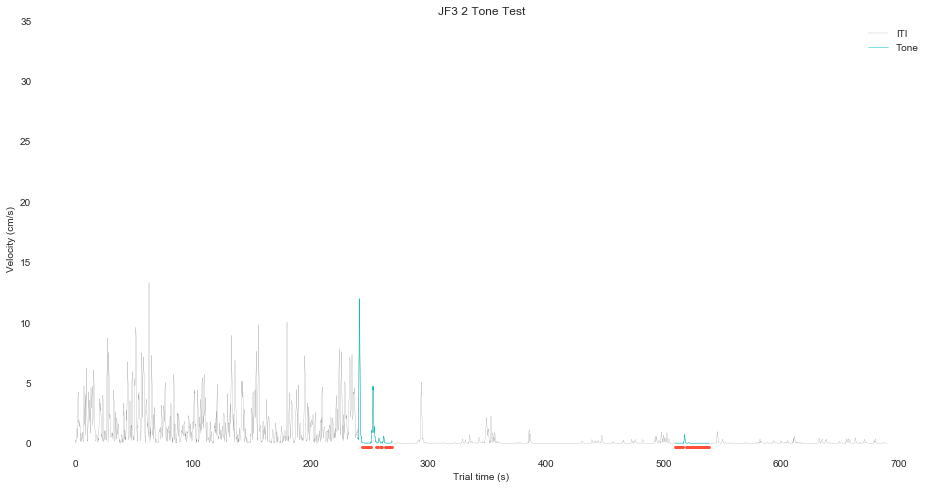

Raw data-Mindlin Project Fear Conditioning-Trial     2.xlsx Track-Arena 4-Subject 1 is JF4 in 2 Tone Test
2 Tone Test
JF4
twotone


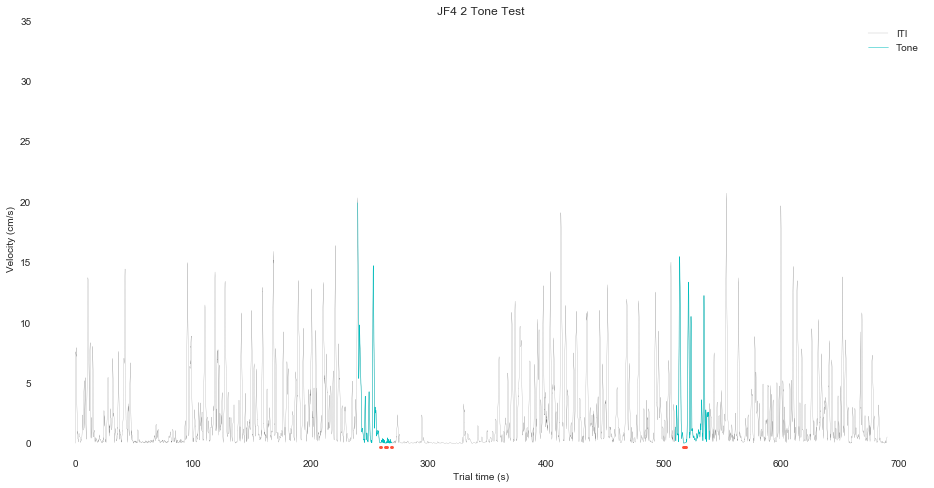

In [5]:
for file in filelist:
    for sheet in sheetlist:
        ## set input/output info
        ID,ctx,anim = sr.animal_read(inpath,file,sheet)
        print(ctx)
        print(ID)
        # Check the context, skipping if the file isn't an excel sheet or properly labeled
        if(ID == "-1" or ID=="nan" or (isinstance(ID,float) and math.isnan(float(ID)))or (isinstance(ID,int) and ID==-1)):
            continue
        elif(ctx == "Fear Conditioning" or ctx == "FC"):
            trialType = 'FC'
            trialTypeFull = 'Fear Conditioning'
            ntones=12
        elif(ctx == "Open Field"):
            trialType = 'OF'
            trialTypeFull = 'Open Field'
            ntones=7
        elif(ctx == "Extinction Learning"):
            trialType = 'ext'
            trialTypeFull = 'Extinction Learning'
            ntones=20
        elif(ctx == "2 Tone Test"):
            trialType = 'twotone'
            trialTypeFull = '2 Tone Test'
            ntones=2
        elif(ctx=="Ext. Retrieval"):
            trialType = "extRet"
            trialTypeFull = 'Extinction Retrieval'
            ntones=3
        else:
            print('\nUnknown Context')
            continue
            
        ## use scaredyrattools function to find where each epoch is
        baseline = sr.find_baseline(anim)
        print(trialType)
        if(trialType=='twotone'):
            tones = srf.find_epoch(anim, '', False, ntones, [240, 510], [270, 540])
            #recovery = srf.find_epoch(anim, '', false, 1, epochStartTime, epochEndTime)
        else:
            tones = sr.find_tones(anim, ntones)
            pretones = sr.find_pretones(anim, ntones)
            shocks = sr.find_shock_responses(anim, ntones)
            pshocks = sr.find_postshocks(anim, ntones)
        
        ## use scaredyrattools function to calculate baseline freezing
        baselineFreezing, bFTs = sr.get_baseline_freezing(baseline, freezingThreshold=0.1, binSecs=1)
        BaselineOutfile = outpath + '/' + trialType + '-baseline-freezing-{}.csv' 
        BaselineOutfile = BaselineOutfile.format(ID)
        bFreezing = pd.concat([baselineFreezing],axis=1)
        bFreezing.to_csv(BaselineOutfile)

        ## use scaredyrattools function to find top n velocities
        mtone = sr.get_top_vels(tones,10,ntones)
        if(trialType!='twotone'):
            mptone = sr.get_top_vels(pretones,10,ntones)
            mshock = sr.get_top_vels(shocks,5,ntones)
            mpshock = sr.get_top_vels(pshocks,10,ntones)

        ## define names of CSV files to save to
        mToneOutfile = outpath + '/' + trialType + '-tone-max-vels-{}.csv' 
        mToneOutfile = mToneOutfile.format(ID)
        if(trialType!='twotone'):
            mPToneOutfile = outpath + '/' + trialType + '-pretone-max-vels-{}.csv' 
            mPToneOutfile = mPToneOutfile.format(ID)

            mShockOutfile = outpath + '/' + trialType + '-shock-max-vels-{}.csv' 
            mShockOutfile = mShockOutfile.format(ID)

            mPShockOutfile = outpath + '/' + trialType + '-postshock-max-vels-{}.csv' 
            mPShockOutfile = mPShockOutfile.format(ID)

        ## send files to previously defined CSVs
        mtone.to_csv(mToneOutfile)
        if(trialType!='twotone'):
            mptone.to_csv(mPToneOutfile)
            mshock.to_csv(mShockOutfile)
            mpshock.to_csv(mPShockOutfile)

        ## use scaredyrattools function to find means
        tmeans = sr.get_means(tones,'Tone',ntones)
        if(trialType!='twotone'):
            ptmeans = sr.get_means(pretones,'Pre-tone',ntones)
            smeans = sr.get_means(shocks,'Shock',ntones)
            pshockmeans = sr.get_means(pshocks,'Post-shock',ntones)
            allmeans = pd.concat([tmeans, ptmeans, smeans, pshockmeans],axis=1)
        else:
            allmeans = tmeans

        ## use scaredyrattools function to find SEMs
        tSEMs = sr.get_SEMs(tones,'Tone',ntones)
        if(trialType!='twotone'):
            ptSEMs = sr.get_SEMs(pretones,'Pre-tone',ntones)
            sSEMs = sr.get_SEMs(shocks,'Shock',ntones)
            pshockSEMs = sr.get_SEMs(pshocks,'Post-shock',ntones)
            allSEMs = pd.concat([tSEMs, ptSEMs, sSEMs, pshockSEMs],axis=1)
        else:
            allSEMs = tSEMs
        ## use scaredyrattools function to find medians
        tmeds = sr.get_meds(tones,'Tone',ntones)
        if(trialType!='twotone'):
            ptmeds = sr.get_meds(pretones,'Pre-tone',ntones)
            smeds = sr.get_meds(shocks,'Shock',ntones)
            pshockmeds = sr.get_meds(pshocks,'Post-shock',ntones)
            allmeds = pd.concat([tmeds, ptmeds, smeds, pshockmeds],axis=1)
        else:
            allmeds=tmeds
        ## sr freezing tools
        toneFreezing, FTs = sr.get_freezing(tones,ntones,freezingThreshold=0.1, binSecs=1)
        if(trialType!='twotone'):
            ptFreezing, ptFTs = sr.get_freezing(pretones,ntones,freezingThreshold=0.1, binSecs=1)
            shockFreezing, shockFTs = sr.get_freezing(shocks,ntones,freezingThreshold=0.1, binSecs=1)
            pshockFreezing, pshockFTs = sr.get_freezing(pshocks,ntones,freezingThreshold=0.1, binSecs=1)
            allFreezing = pd.concat([toneFreezing, ptFreezing, shockFreezing, pshockFreezing],axis=1)
        else:
            allFreezing=toneFreezing
        ## sr darting tools
        toneDarting, DTs = sr.get_darting(tones,ntones,dartThreshold=20, binSecs=2)
        if(trialType!='twotone'):
            ptDarting, ptDTs = sr.get_darting(pretones,ntones,dartThreshold=20, binSecs=2)
            shockDarting, shockDTs = sr.get_darting(shocks,ntones,dartThreshold=20, binSecs=2)
            pshockDarting, pshockDTs = sr.get_darting(pshocks,ntones,dartThreshold=20, binSecs=2)
            allDarting = pd.concat([toneDarting, ptDarting, shockDarting, pshockDarting],axis=1)
        else:
            allDarting = toneDarting
        ## define names of CSV files to save to
        meanOutfile = outpath + '/' + trialType + '-mean-{}.csv' 
        meanOutfile = meanOutfile.format(ID)

        SEMOutfile = outpath + '/' + trialType + '-SEM-{}.csv' 
        SEMOutfile = SEMOutfile.format(ID)

        medOutfile = outpath + '/' + trialType + '-med-{}.csv' 
        medOutfile = medOutfile.format(ID)

        freezingOutfile = outpath + '/' + trialType + '-freezing-{}.csv'
        freezingOutfile = freezingOutfile.format(ID)
        
        dartingOutfile = outpath + '/' + trialType + '-darting-{}.csv'
        dartingOutfile = dartingOutfile.format(ID)

        allmeans.to_csv(meanOutfile)
        allSEMs.to_csv(SEMOutfile)
        allmeds.to_csv(medOutfile)
        allFreezing.to_csv(freezingOutfile)
        allDarting.to_csv(dartingOutfile)

        ## plot stuff
        vels = pd.DataFrame(anim['Velocity'])

        plt.style.use('seaborn-white')
        plt.figure(figsize=(16,8),facecolor='white',edgecolor='white')

        # Plots main velocity in black
        line1, = plt.plot(vels,color='k',linewidth=0.1,label='ITI')

        # Loops through tones, plots each one in cyan
        i = 1
        if(trialType!='twotone'):
            while i <= ntones:            
                tone = sr.find_tone_vels(anim,i)
                line2, = plt.plot(tone,color='c',linewidth=0.5,label='Tone')            
                i += 1
        else:
            tone = srf.find_epoch_vels(tones,ntones)
            while i <= ntones:            
                line2, = plt.plot(tone[i],color='c',linewidth=0.5,label='Tone')
                i+=1
        if(trialType!='twotone'):
            # Loops through shocks, plots each one in magenta
            i = 1
            while i <= ntones:
                sresponse = sr.find_shock_vels(anim,i)
                line3, = plt.plot(sresponse,color='m',linewidth=0.5,label='Shock')
                i += 1

        # Loops through freezing bins, plots each below the x-axis
        for timebin in FTs:
            plt.plot([timebin[0],timebin[1]],[-0.3,-0.3],color='#ff4f38',linewidth=3)

        # Loops through darting bins, plots each below the x-axis
        for timebin in DTs:
            plt.plot([timebin[0],timebin[1]],[-0.7,-0.7],color='#167512',linewidth=3)
            
        plt.ylim(-1,35)

        sns.despine(left=True, bottom=True, right=True)
        plt.title(ID + " " + trialTypeFull)
        if(trialType!='twotone'):
            plt.legend(handles=[line1,line2,line3])
        else:
            plt.legend(handles=[line1,line2])
        plt.ylabel('Velocity (cm/s)')
        plt.xlabel('Trial time (s)')

        ## define where to save the fig
        fname = outpath + '/' + trialType + '-plot-{}'
        fname = fname.format(ID)

        plt.savefig(fname, dpi=300)

        plt.show()
        plt.close()